In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from tqdm import tqdm
from matplotlib import pyplot as plt

from plotly import express as px
import plotly.graph_objects as go
import plotly.io as pio


In this notebook, the data is going to be preprocess, to be ready for the data exploration and model creation

## Functions

In [40]:
def rename_uname(df):
    for i , columns in enumerate(df.columns.levels):
        column_new = columns.tolist()
        for j, row in enumerate(column_new):
            row = str(row)
            if 'Unnamed' in row:
                column_new[j] = ""
            if "NO" == row:
                column_new = ""
        df = df.rename(columns=dict(zip(columns.tolist(), column_new)),
            level = i)
    return df

def categorize_genre(value):
  ending = value[-7:] 
  if ending == "Mujeres":
    return "Mujeres"
  elif ending == "Hombres":
    return "Hombres"
  else:
    return "Ambos sexos"

def renta_rename(df):
    df = rename_uname(df).reset_index(drop=True)
    years = list(set([col[0] for col in df.columns][1:]))
    df.columns = [''.join(str(col)).strip() for col in df.columns.values]
    df.columns = [col.replace(' ','_').lower() for col in df.columns.values]
    df.columns = [col.replace(',','') for col in df.columns.values]


    df = df.rename(columns={
        "('distrito_/_barrio'_'')": 'distrito_barrio',
        f"({years[1]}_'renta_media_por_persona_')": f'renta_media_por_persona_{years[1]}',
        f"({years[1]}_'renta_media_por_hogar')": f'renta_media_por_hogar_{years[1]}',
        f"({years[0]}_'renta_media_por_persona_')": f'renta_media_por_persona_{years[0]}',
        f"({years[0]}_'renta_media_por_hogar')": f'renta_media_por_hogar_{years[0]}',
    })
    df = df.dropna()
    df['distrito_barrio'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
    df['distrito_barrio'] = df['distrito_barrio'].str.strip()
    return df


def clean_renta(df1):
  list_columns = df1.columns.to_list()
  distritos = df1.distrito_barrio
  list_columns = df1.columns.to_list()
  distritos = df1.distrito_barrio
  list_years = list_columns[1:]
  list_years = [name.split('_')[-1] for name in list_years]
  list_years = list(set(list_years))

  rent_1 = pd.concat([distritos,df1[list_columns[1:3]]],axis=1)
  rent_2 = pd.concat([distritos,df1[list_columns[3:6]]],axis=1)
  rent_1['year'] = list_years[1]
  rent_2['year'] = list_years[0]
  rent_1.columns = rent_1.columns.str.replace(r'_\d+', '', regex=True)
  rent_2.columns = rent_2.columns.str.replace(r'_\d+', '', regex=True)

  rents = pd.concat([rent_1, rent_2])
  return rents

## Paro

Preprocessing the data that came from the ayuntamiento de madrid and save it in csv format.

In [41]:
paro_madrid_neigh = pd.read_excel('../data/madrid/raw/paro/paro_madrid.xlsx',header=[0,1,2])
paro_madrid_distric = pd.read_excel('../data/madrid/raw/paro/paro_madrid.xlsx',header=[0,2])


In [42]:
paro_madrid = rename_uname(paro_madrid_neigh).reset_index(drop=True)
paro_madrid.columns = [' '.join(col).strip() for col in paro_madrid.columns.values]
paro_madrid.columns = [col.replace(' ','_').lower() for col in paro_madrid.columns.values]
paro_madrid = paro_madrid.drop(paro_madrid.columns[0], axis=1)

In [43]:
paro_madrid_dst = rename_uname(paro_madrid_distric).reset_index(drop=True)
paro_madrid_dst.columns = [' '.join(col).strip() for col in paro_madrid_dst.columns.values]
paro_madrid_dst.columns = [col.replace(' ','_').lower() for col in paro_madrid_dst.columns.values]
paro_madrid_dst = paro_madrid_dst.drop(paro_madrid_dst.columns[0], axis=1)

In [44]:
paro_madrid = paro_madrid.drop(columns=['ciudad_de_madrid_ciudad_de_madrid_ambos_sexos'])
paro_madrid.columns = ['_'.join(col.split('_')[3:]) for col in paro_madrid.columns.values]
paro_madrid = paro_madrid.drop(columns=['no_consta_ambos_sexos'])
paro_madrid.columns = [re.sub(r'\d+_', '', col) for col in paro_madrid.columns.values]
paro_madrid.columns = [re.sub(r'\vallecas', '', col) for col in paro_madrid.columns.values]

In [45]:
paro_madrid_dst = paro_madrid_dst.loc[:, ~paro_madrid_dst.columns.str.contains('.\d+$')]

paro_madrid_dst = paro_madrid_dst.drop(columns=['ciudad_de_madrid_ambos_sexos'])
paro_madrid_dst.columns = ['_'.join(col.split('_')[3:]) for col in paro_madrid_dst.columns.values]
paro_madrid_dst = paro_madrid.drop(columns=['no_consta_ambos_sexos'])
paro_madrid_dst.columns = [re.sub(r'\d+_', '', col) for col in paro_madrid_dst.columns.values]
paro_madrid_dst.columns = [re.sub(r'\vallecas', '', col) for col in paro_madrid_dst.columns.values]

In [46]:
total_paro = pd.DataFrame(paro_madrid_dst.sum())
total_paro['district'] = total_paro.index
total_paro.reset_index(drop=True,inplace=True)
total_paro.rename(columns={0:'total'}, inplace=True)
total_paro = total_paro.reindex(columns=['district','total'])
total_paro['total'] = total_paro['total'].astype(int)
total_paro['district'] = total_paro.district.str.title()
total_paro['genre'] = total_paro['district'].apply(categorize_genre)

genre_map = {"_Mujeres": "", "_Hombres": "", "_Ambos_Sexos": ""}
total_paro['district'] = total_paro['district'].replace(genre_map, regex=True)
total_paro['district'] = total_paro['district'].str.replace('_',' ')
total_paro['district'] = total_paro['district'].str.replace('Vallecas ','')

total_paro = total_paro[~total_paro['district'].isin(['No Consta','Ciudad De Madrid'])]
total_paro.to_csv('../data/madrid/cleaned/paro_by_district.csv')

In [47]:
total_paro.sort_values(by='total', ascending=False)

,district,total,genre
91,Puente De Vallecas,188449,Ambos sexos
75,Carabanchel,168234,Ambos sexos
67,Latina,138069,Ambos sexos
123,Villaverde,115411,Ambos sexos
106,Ciudad Lineal,108214,Ambos sexos
...,...,...,...
457,Atalaya,277,Mujeres
229,El Plantío,265,Hombres
171,Atocha,265,Hombres
283,Atalaya,179,Hombres


In [179]:
paro_by_neighbour = pd.read_csv('../data/madrid/cleaned/paro_by_neighbourhood.csv')
paro_by_district = pd.read_csv('../data/madrid/cleaned/paro_by_district.csv')

In [180]:
paro_by_neighbour = paro_by_neighbour.rename(columns={'district':'neighbourhood','total':'paro_total'})

In [181]:
paro_by_neighbour_women = paro_by_neighbour[paro_by_neighbour['genre'] == 'Mujeres'][['neighbourhood','paro_total']]
paro_by_neighbour_women = paro_by_neighbour_women.rename(columns={'paro_total':'paro_women'})


paro_by_neighbour_men = paro_by_neighbour[paro_by_neighbour['genre'] == 'Hombres'][['neighbourhood','paro_total']]
paro_by_neighbour_men = paro_by_neighbour_men.rename(columns={'paro_total':'paro_men'})


paro_by_neighbour_total = paro_by_neighbour[paro_by_neighbour['genre'] == 'Ambos sexos'][['neighbourhood','paro_total']]
paro_by_neighbour_total = paro_by_neighbour_total.rename(columns={'paro_total':'paro_all'})


## Vivienda

### Datos inmobiliarios

In [119]:
df_fotocasa = pd.read_csv('../data/madrid/cleaned/fotocasa/fotocasa_2023_located_districts.csv')
df_fotocasa.shape

(14130, 19)

In [120]:

df_fotocasa['date_scraped'] = pd.to_datetime('2024-04-09')

df_fotocasa.head()



,Address,Zipcode,Longitude,Latitude,Price,Date,Rooms,Bathrooms,Surface,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool,neighbourhood,district_geolocated,date_scraped
0,Retiro,28007.0,40.402584,-3.672911,445000,2023-06-07,2,2,102,0,1,1,1,0,0,0,1,Adelfas,Retiro,2024-04-09
1,Calle de Pobladura del Valle San Blas,28037.0,40.423885,-3.621543,108000,2023-07-11,3,1,53,6,0,0,0,0,0,0,0,Arcos,San Blas - Canillejas,2024-04-09
2,Calle de Pobladura del Valle San Blas,28037.0,40.423680,-3.621510,108000,2023-07-10,3,1,53,0,0,0,0,0,0,0,0,Arcos,San Blas - Canillejas,2024-04-09
3,Calle Amparo Centro,28012.0,40.407387,-3.701162,235000,2023-04-16,2,1,68,0,0,1,1,0,0,0,0,Embajadores,Centro,2024-04-09
4,Barrio de Salamanca,28001.0,40.420685,-3.688424,2350000,2022-09-09,2,2,177,7,1,1,0,0,1,0,0,Recoletos,Salamanca,2024-04-09


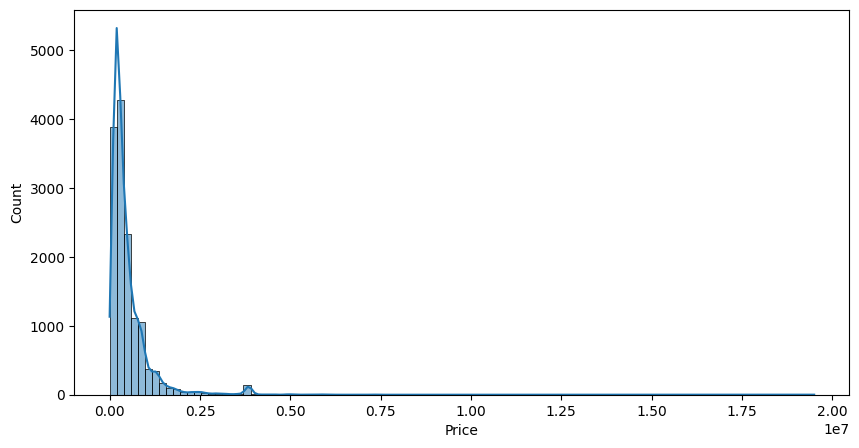

In [121]:
fig = plt.figure(figsize=(10,5))

sns.histplot(data=df_fotocasa, x='Price', bins=100, kde=True)
plt.show()

In [122]:
df_fotocasa.isna().sum()

Address                0
Zipcode                5
Longitude              0
Latitude               0
Price                  0
Date                   0
Rooms                  0
Bathrooms              0
Surface                0
Floor                  0
Elevator               0
Air_Conditioner        0
Heater                 0
Parking                0
Balcony                0
Terrace                0
Swimming_Pool          0
neighbourhood          6
district_geolocated    6
date_scraped           0
dtype: int64

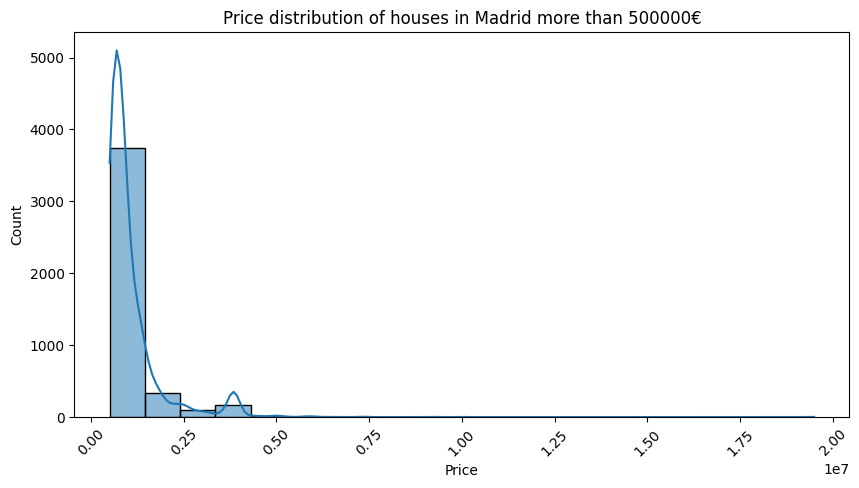

In [123]:
fig = plt.figure(figsize=(10,5))

plt.title('Price distribution of houses in Madrid more than 500000€')
sns.histplot(data=df_fotocasa[df_fotocasa['Price'] > 500000], x='Price', bins=20, kde=True)
plt.xticks(rotation=45)
plt.show()

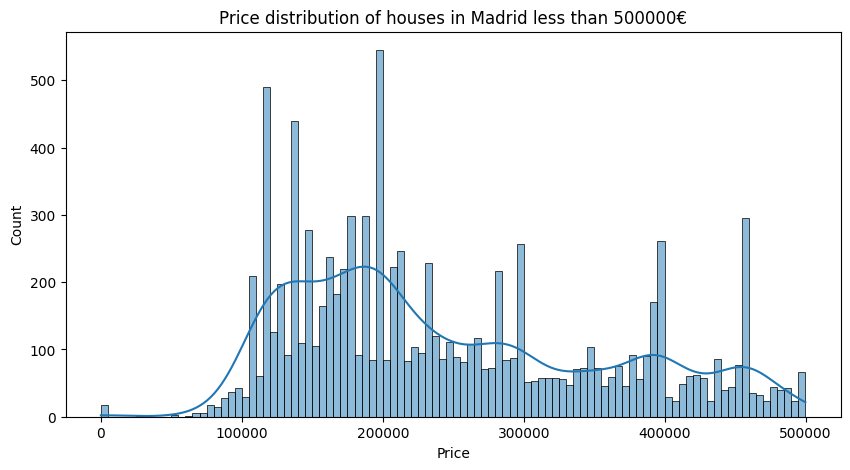

In [124]:
fig = plt.figure(figsize=(10,5))
plt.title('Price distribution of houses in Madrid less than 500000€')

sns.histplot(data=df_fotocasa[df_fotocasa['Price'] < 500000], x='Price', bins=100, kde=True)
plt.show()

Outliers

<Axes: xlabel='Price'>

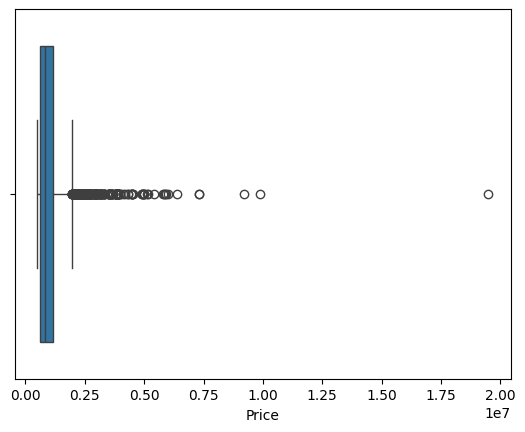

In [125]:
sns.boxplot(data=df_fotocasa[df_fotocasa['Price'] > 500000], x='Price')

### Vivienda m2

In [126]:
df_housing = pd.read_excel('../data/madrid/raw/vivienda_segunda_mano.xlsx')
df_housing = df_housing.replace('-',0)
df_housing.rename(columns={'Unnamed: 0':'district', 'Unnamed: 1':'barrio'}, inplace=True)
df_housing['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
df_housing['barrio'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')

/tmp/ipykernel_125682/3873418861.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_housing['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
/tmp/ipykernel_125682/3873418861.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

In [127]:
df_housing_yearly = pd.melt(df_housing, id_vars=['barrio', 'district'], var_name='year', value_name='price')
df_housing_yearly['price'] = df_housing_yearly['price'].astype(float)
df_housing_yearly['year'] = df_housing_yearly['year'].astype(int)
df_housing_yearly.to_csv('../data/madrid/cleaned/sq2_madrid_yearly.csv')
df_housing_yearly.head()

,barrio,district,year,price
0,Ciudad de Madrid,Ciudad de Madrid,2017,3.285
1,Centro,Centro,2017,4.599
2,Palacio,Centro,2017,4.474
3,Embajadores,Centro,2017,4.017
4,Cortes,Centro,2017,4.842


In [128]:
price_district_m2 = df_housing_yearly.groupby(['district','year']).agg({'price':'mean'}).reset_index()
price_neighbourhood_m2 = df_housing_yearly.groupby(['barrio','year']).agg({'price':'sum'}).reset_index()
price_district_m2

,district,year,price
0,Arganzuela,2017,2.638250
1,Arganzuela,2018,3.447000
2,Arganzuela,2019,3.494875
3,Arganzuela,2020,3.410750
4,Arganzuela,2021,3.582000
...,...,...,...
127,Ciudad de Madrid,2018,3.844000
128,Ciudad de Madrid,2019,3.732000
129,Ciudad de Madrid,2020,3.682000
130,Ciudad de Madrid,2021,3.700000


In [129]:
month_map = {'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
             'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12}

In [130]:

df_housing_month = pd.read_excel('../data/madrid/raw/vivienda_segunda_mano_mes.xlsx')
df_housing_month = df_housing_month.replace('-',0)
df_housing_month.rename(columns={'Unnamed: 0':'año', 'Unnamed: 1':'district'}, inplace=True)
df_housing_month['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
df_housing_month['district'] = df_housing_month['district'].str.strip()

df_housing_month = pd.melt(df_housing_month, id_vars=['año', 'district'], var_name='month', value_name='price')
df_housing_month['price'] = df_housing_month['price'].astype(float)
df_housing_month['month_n'] = df_housing_month['month'].map(month_map).astype(int)
df_housing_month

/tmp/ipykernel_125682/2173044436.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_housing_month['district'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')


,año,district,month,price,month_n
0,2006,Ciudad de Madrid,Enero,0.000,1
1,2006,Centro,Enero,0.000,1
2,2006,Arganzuela,Enero,0.000,1
3,2006,Retiro,Enero,0.000,1
4,2006,Salamanca,Enero,0.000,1
...,...,...,...,...,...
4759,2023,Villa de Vallecas,Diciembre,2.691,12
4760,2023,Vicálvaro,Diciembre,2.846,12
4761,2023,San Blas-Canillejas,Diciembre,2.852,12
4762,2023,Barajas,Diciembre,3.406,12


In [131]:
df_housing_month['month_w_price'] = df_housing_month[df_housing_month['price'] > 0.0].groupby(['district','año'])['price'].transform('count')
df_housing_month['month_w_price'] = df_housing_month['month_w_price'].fillna(0)
df_housing_month = df_housing_month[df_housing_month['month_w_price'] >= 9]
df_housing_month = df_housing_month.groupby(['district','año']).agg({'price':'mean'}).reset_index()

In [132]:
df_housing_month[df_housing_month['año'] == 2006]
df_housing_month = df_housing_month.drop(105)
df_housing_month.año.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2007])

In [133]:
df_housing_month = df_housing_month[~df_housing_month.año.isin([2007, 2008, 2009, 2023])]
df_housing_month.año.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022])

In [134]:
df_housing_concat = pd.concat([df_housing_month, price_district_m2])
df_housing_concat = df_housing_concat.fillna('-')
df_housing_concat['date'] = df_housing_concat['año'].astype(str) + df_housing_concat['year'].astype(str)
df_housing_concat['date'] = df_housing_concat['date'].str.replace('-','').astype(float)
df_housing_concat['date'] = df_housing_concat['date'].astype(int)
df_housing_concat = df_housing_concat.drop(columns=['año','year'])

In [146]:
df_housing_concat = df_housing_concat.rename(columns={'date':'m2_date', 'price':'price_m2'})

In [147]:
df_housing_concat.to_csv('../data/madrid/cleaned/sq2_madrid_yearly.csv')

## Renta

In [65]:
renta_15_16 = pd.read_excel('../data/madrid/raw/renta/renta_15_16.xlsx',skiprows=[0,1,2,3,4], header=[0,1])  
renta_16_17 = pd.read_excel('../data/madrid/raw/renta/renta17_16.xlsx', skiprows=[0,1,2,3,4], header=[0,1])    
renta_17_18 = pd.read_excel('../data/madrid/raw/renta/renta17_18.xlsx', skiprows=[0,1,2,3,4], header=[0,1])    
renta_18_20 = pd.read_excel('../data/madrid/raw/renta/renta19_20.xlsm', skiprows=[0,1,2,3,4], header=[0,1])   

In [66]:
renta_15_16 = renta_rename(renta_15_16)
renta_16_17 = renta_rename(renta_16_17)
renta_17_18 =  renta_rename(renta_17_18)
renta_19_20 = renta_rename(renta_18_20)

/tmp/ipykernel_125682/2165674989.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distrito_barrio'].replace(regex=True,inplace=True,to_replace=r'\d+\.',value=r'')
/tmp/ipykernel_125682/2165674989.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [35]:
renta_15_16 = clean_renta(renta_15_16)
renta_16_17 = clean_renta(renta_16_17)
renta_17_18 =  clean_renta(renta_17_18)
renta_19_20 = clean_renta(renta_19_20)

## Points

In [623]:
points_raw = pd.read_csv('../data/points/amenity.csv')
points_raw.shape

(32672, 10)

## Dataset Creation

In [67]:
#need to find which categories we wanna locate 
df_amenity = pd.read_csv('../data/points/amenity.csv')
df_amenity.category.unique()

array(['fuel', nan, 'cinema', 'parking_entrance', 'restaurant', 'pub',
       'theatre', 'police', 'parking', 'place_of_worship', 'fast_food',
       'pharmacy', 'bar', 'retail', 'taxi', 'bicycle_parking', 'cafe',
       'bank', 'bench', 'university', 'clinic', 'drinking_water',
       'post_box', 'post_office', 'recycling', 'veterinary', 'atm',
       'social_facility', 'dentist', 'kindergarten', 'nightclub',
       'bicycle_rental', 'library', 'waste_disposal', 'ice_cream',
       'internet_cafe', 'fountain', 'school', 'music_school',
       'language_school', 'dancing_school', 'vending_machine',
       'marketplace', 'bus_station', 'toilets', 'telephone',
       'arts_centre', 'college', 'training', 'hospital', 'doctors',
       'car_rental', 'casino', 'water_point', 'waste_basket',
       'social_centre', 'courthouse', 'car_wash', 'biergarten',
       'community_centre', 'driving_school', 'vacuum_cleaner', 'prison',
       'brothel', 'satellite_dish', 'grave_yard', 'food_court',
  

In [68]:
df_housing = pd.read_csv('../data/madrid/cleaned/fotocasa/fotocasa_2023_located_districts.csv')
df_housing.shape

(14130, 19)

In [69]:
df_housing.rename(columns={'district_geolocated':'distrito_barrio'}, inplace=True)

In [70]:
df_housing.columns = df_housing.columns.str.lower()
df_housing['zipcode'] = df_housing['zipcode'].fillna(0)
df_housing['zipcode'] = df_housing['zipcode'].astype(int)
df_housing['house_id'] = df_housing.index

In [71]:
df_airbnb = pd.read_csv('../data/points/points_count/housing_airbnb.csv')
df_college = pd.read_csv('../data/points/points_count/housing_college.csv')
df_dentist = pd.read_csv('../data/points/points_count/housing_dentist.csv')
df_fast_food = pd.read_csv('../data/points/points_count/housing_fast_food.csv')
df_jewelry = pd.read_csv('../data/points/points_count/housing_jewelry.csv')
df_university = pd.read_csv('../data/points/points_count/housing_university.csv')
df_restaurant = pd.read_csv('../data/points/points_count/housing_restaurant.csv')
df_hospital = pd.read_csv('../data/points/points_count/housing_hospital.csv')
df_pharmacy = pd.read_csv('../data/points/points_count/housing_pharmacies.csv')
df_supermarket = pd.read_csv('../data/points/points_count/housing_supermarket.csv')
df_airbnb.shape, df_college.shape, df_dentist.shape, df_fast_food.shape, df_jewelry.shape, df_university.shape, df_restaurant.shape, df_hospital.shape

((3237335, 2),
 (6265, 2),
 (28298, 2),
 (105914, 2),
 (19743, 2),
 (1312, 2),
 (682458, 2),
 (955, 2))

In [72]:
df_airbn = df_airbnb.groupby('house_id').agg(count=(df_airbnb.columns[1],'count')).reset_index()
df_college = df_college.groupby('house_id').agg(count=(df_college.columns[1],'count')).reset_index()
df_dentist = df_dentist.groupby('house_id').agg(count=(df_dentist.columns[1],'count')).reset_index()
df_fast_food = df_fast_food.groupby('house_id').agg(count=(df_fast_food.columns[1],'count')).reset_index()
df_jewelry = df_jewelry.groupby('house_id').agg(count=(df_jewelry.columns[1],'count')).reset_index()
df_university = df_university.groupby('house_id').agg(count=(df_university.columns[1],'count')).reset_index()
df_restaurant = df_restaurant.groupby('house_id').agg(count=(df_restaurant.columns[1],'count')).reset_index()
df_hospital = df_hospital.groupby('house_id').agg(count=(df_hospital.columns[1],'count')).reset_index()
df_pharmacy = df_pharmacy.groupby('house_id').agg(count=(df_pharmacy.columns[1],'count')).reset_index()
df_supermarket = df_supermarket.groupby('house_id').agg(count=(df_supermarket.columns[1],'count')).reset_index()

In [73]:
df_housing_left = df_housing.merge(df_airbn, on='house_id', how='left', suffixes=('', '_airbnb'))
df_housing_left = df_housing_left.merge(df_college, on='house_id', how='left', suffixes=('', '_college_500'))
df_housing_left = df_housing_left.merge(df_dentist, on='house_id', how='left', suffixes=('', '_dentist_500'))
df_housing_left = df_housing_left.merge(df_fast_food, on='house_id', how='left', suffixes=('', '_fast_food_500'))
df_housing_left = df_housing_left.merge(df_jewelry, on='house_id', how='left', suffixes=('', '_jewelry_500'))
df_housing_left = df_housing_left.merge(df_university, on='house_id', how='left', suffixes=('', '_university_500'))
df_housing_left = df_housing_left.merge(df_restaurant, on='house_id', how='left', suffixes=('', '_restaurant_500'))
df_housing_left = df_housing_left.merge(df_hospital, on='house_id', how='left', suffixes=('', '_hospital_500'))
df_housing_left = df_housing_left.merge(df_pharmacy, on='house_id', how='left', suffixes=('', '_pharmacy_500'))
df_housing_left = df_housing_left.merge(df_pharmacy, on='house_id', how='left', suffixes=('', '_supermarket_500'))


In [74]:
df_housing_left = df_housing_left.rename(columns={'count':'count_airbnb_500'})

In [75]:
df_housing_left[df_housing_left.columns[df_housing_left.columns.str.contains('count')]].fillna(0, inplace=True)

/tmp/ipykernel_125682/2548365896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_housing_left[df_housing_left.columns[df_housing_left.columns.str.contains('count')]].fillna(0, inplace=True)


In [76]:
df_housing_left = df_housing_left[~df_housing_left['neighbourhood'].isna()]
df_housing_left = df_housing_left.fillna(0)
df_housing_left.isna().sum()

address                  0
zipcode                  0
longitude                0
latitude                 0
price                    0
date                     0
rooms                    0
bathrooms                0
surface                  0
floor                    0
elevator                 0
air_conditioner          0
heater                   0
parking                  0
balcony                  0
terrace                  0
swimming_pool            0
neighbourhood            0
distrito_barrio          0
house_id                 0
count_airbnb_500         0
count_college_500        0
count_dentist_500        0
count_fast_food_500      0
count_jewelry_500        0
count_university_500     0
count_restaurant_500     0
count_hospital_500       0
count_pharmacy_500       0
count_supermarket_500    0
dtype: int64

In [77]:
df_housing_left2 = pd.merge(df_housing_left, renta_15_16, on='distrito_barrio', how='inner')
df_housing_left2 = pd.merge(df_housing_left2, renta_16_17, on='distrito_barrio', how='inner')
df_housing_left2 = pd.merge(df_housing_left2, renta_17_18, on='distrito_barrio', how='inner')
df_housing_left2 = pd.merge(df_housing_left2, renta_19_20, on='distrito_barrio', how='inner')
df_housing_left2

,address,zipcode,longitude,latitude,price,date,rooms,bathrooms,surface,floor,...,renta_media_por_persona_2016_y,renta_media_por_hogar_2016_y,renta_media_por_persona_2018,renta_media_por_hogar_2018,renta_media_por_persona_2017_y,renta_media_por_hogar_2017_y,renta_media_por_persona_2020,renta_media_por_hogar_2020,renta_media_por_persona_2019,renta_media_por_hogar_2019
0,Retiro,28007,40.402584,-3.672911,445000,2023-06-07,2,2,102,0,...,21504.0,52963.0,22706.0,55775.0,21598.0,53111.0,23227.0,56302.0,23262.0,57027.0
1,Calle Amparo Centro,28012,40.407387,-3.701162,235000,2023-04-16,2,1,68,0,...,16147.0,32458.0,17932.0,36072.0,16711.0,33473.0,18314.0,36984.0,18789.0,38171.0
2,Barrio de Salamanca,28001,40.420685,-3.688424,2350000,2022-09-09,2,2,177,7,...,24433.0,57147.0,26255.0,61466.0,24683.0,57720.0,25932.0,60401.0,25770.0,60435.0
3,Chamberí,28010,40.436382,-3.698839,1100000,2023-06-12,4,2,167,10,...,22499.0,50882.0,24112.0,54327.0,22897.0,51644.0,24913.0,55757.0,24881.0,56073.0
4,Calle de la Laguna Carabanchel,28025,40.387520,-3.741732,139000,2023-06-15,2,1,70,9,...,10872.0,28301.0,11327.0,29842.0,10988.0,28721.0,11713.0,30890.0,11679.0,31190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12473,De las Minas Centro,28004,40.425182,-3.706110,658000,2023-06-13,2,2,128,9,...,16147.0,32458.0,17932.0,36072.0,16711.0,33473.0,18314.0,36984.0,18789.0,38171.0
12474,Federico Grases Carabanchel,28025,40.375540,-3.744016,115000,2023-06-08,2,1,63,8,...,10872.0,28301.0,11327.0,29842.0,10988.0,28721.0,11713.0,30890.0,11679.0,31190.0
12475,Avenida de las Águilas Latina,28044,40.382534,-3.772753,164500,2023-05-31,2,1,60,7,...,12232.0,30490.0,12749.0,31872.0,12370.0,30847.0,13261.0,32957.0,13179.0,33237.0
12476,Calle de Pablo Sarasate Latina,28047,40.404716,-3.731530,174900,2023-06-05,3,2,73,0,...,12232.0,30490.0,12749.0,31872.0,12370.0,30847.0,13261.0,32957.0,13179.0,33237.0


In [81]:
suffix = "_y" 
cols_to_drop = df_housing_left2.filter(like=suffix).columns
df_housing_left2 = df_housing_left2.drop(columns=cols_to_drop)

In [83]:
df_housing_left2.columns = df_housing_left2.columns.str.replace('_x','')
df_housing_left2.columns

Index(['address', 'zipcode', 'longitude', 'latitude', 'price', 'date', 'rooms',
       'bathrooms', 'surface', 'floor', 'elevator', 'air_conditioner',
       'heater', 'parking', 'balcony', 'terrace', 'swimming_pool',
       'neighbourhood', 'distrito_barrio', 'house_id', 'count_airbnb_500',
       'count_college_500', 'count_dentist_500', 'count_fast_food_500',
       'count_jewelry_500', 'count_university_500', 'count_restaurant_500',
       'count_hospital_500', 'count_pharmacy_500', 'count_supermarket_500',
       'renta_media_por_persona_2016', 'renta_media_por_hogar_2016',
       'renta_media_por_persona_2015', 'renta_media_por_hogar_2015',
       'renta_media_por_persona_2017', 'renta_media_por_hogar_2017',
       'renta_media_por_persona_2018', 'renta_media_por_hogar_2018',
       'renta_media_por_persona_2020', 'renta_media_por_hogar_2020',
       'renta_media_por_persona_2019', 'renta_media_por_hogar_2019'],
      dtype='object')

In [135]:
df_housing_concat = df_housing_concat.rename(columns={'distrito_barrio':'district'})
df_housing_left2 = df_housing_left2.rename(columns={'distrito_barrio':'district'})

In [136]:
df_housing_concat.district = df_housing_concat.district.apply(lambda x: x.strip())

In [152]:
len(df_housing_left2.district.unique()), len(df_housing_concat.district.unique())

(18, 22)

In [157]:
df_housing_left2.shape

(12478, 42)

In [153]:
df_housing_concat.district.unique()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Ciudad de Madrid',
       'Fuencarral-El Pardo', 'Hortaleza', 'Latina', 'Moncloa-Aravaca',
       'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca',
       'San Blas-Canillejas', 'Tetuán', 'Usera', 'Vicálvaro',
       'Villa de Vallecas', 'Villaverde'], dtype=object)

In [166]:
df_merged = df_housing_left2.merge(df_housing_concat, on='district', how='left')

In [182]:
df_merged.columns

Index(['address', 'zipcode', 'longitude', 'latitude', 'price', 'date', 'rooms',
       'bathrooms', 'surface', 'floor', 'elevator', 'air_conditioner',
       'heater', 'parking', 'balcony', 'terrace', 'swimming_pool',
       'neighbourhood', 'district', 'house_id', 'count_airbnb_500',
       'count_college_500', 'count_dentist_500', 'count_fast_food_500',
       'count_jewelry_500', 'count_university_500', 'count_restaurant_500',
       'count_hospital_500', 'count_pharmacy_500', 'count_supermarket_500',
       'renta_media_por_persona_2016', 'renta_media_por_hogar_2016',
       'renta_media_por_persona_2015', 'renta_media_por_hogar_2015',
       'renta_media_por_persona_2017', 'renta_media_por_hogar_2017',
       'renta_media_por_persona_2018', 'renta_media_por_hogar_2018',
       'renta_media_por_persona_2020', 'renta_media_por_hogar_2020',
       'renta_media_por_persona_2019', 'renta_media_por_hogar_2019',
       'price_m2', 'm2_date'],
      dtype='object')

In [173]:
df_merged.describe()

,zipcode,longitude,latitude,price,rooms,bathrooms,surface,floor,elevator,air_conditioner,...,renta_media_por_persona_2017,renta_media_por_hogar_2017,renta_media_por_persona_2018,renta_media_por_hogar_2018,renta_media_por_persona_2020,renta_media_por_hogar_2020,renta_media_por_persona_2019,renta_media_por_hogar_2019,price_m2,m2_date
count,237082.000000,237082.000000,237082.000000,2.370820e+05,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,...,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000,237082.000000
mean,27997.423065,40.414785,-3.688892,5.102809e+05,2.580702,1.724876,100.575172,5.449912,0.643853,0.471229,...,16498.545280,39146.833547,17386.251563,41315.496394,17761.532297,42062.270236,17808.667895,42537.615403,3.434443,2017.105263
std,757.395420,0.030259,0.036852,6.330485e+05,1.269702,1.059027,68.537363,3.820493,0.478860,0.499173,...,5031.752602,11458.835441,5469.323585,12322.168632,5309.776298,11712.151938,5314.282364,11650.992038,1.351995,3.625861
min,0.000000,40.331640,-3.794892,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9552.000000,25527.000000,9860.000000,26652.000000,10239.000000,27714.000000,10211.000000,27975.000000,0.609571,2010.000000
25%,28009.000000,40.392450,-3.706675,1.799000e+05,2.000000,1.000000,62.000000,3.000000,0.000000,0.000000,...,12114.000000,30847.000000,12545.000000,31872.000000,13099.000000,32957.000000,12976.000000,33237.000000,2.180417,2014.000000
50%,28019.000000,40.411644,-3.696012,3.158750e+05,3.000000,1.000000,85.000000,6.000000,1.000000,0.000000,...,16711.000000,33473.000000,17932.000000,36072.000000,18314.000000,36984.000000,18789.000000,38171.000000,3.326900,2018.000000
75%,28036.000000,40.433174,-3.670294,5.850000e+05,3.000000,2.000000,118.000000,8.000000,1.000000,1.000000,...,18620.000000,49695.000000,19759.000000,52944.000000,19890.000000,52880.000000,20044.000000,53836.000000,4.692857,2020.000000
max,43896.000000,40.507042,-3.544990,1.950000e+07,33.000000,10.000000,2160.000000,21.000000,1.000000,1.000000,...,26267.000000,65995.000000,28190.000000,70735.000000,27719.000000,69202.000000,27634.000000,69558.000000,6.657143,2022.000000


In [177]:
df_merged.select_dtypes(exclude='object').corr()

,zipcode,longitude,latitude,price,rooms,bathrooms,surface,floor,elevator,air_conditioner,...,renta_media_por_persona_2017,renta_media_por_hogar_2017,renta_media_por_persona_2018,renta_media_por_hogar_2018,renta_media_por_persona_2020,renta_media_por_hogar_2020,renta_media_por_persona_2019,renta_media_por_hogar_2019,price_m2,m2_date
zipcode,1.000000e+00,1.449340e-04,-4.018259e-03,-1.234001e-02,-1.974675e-02,-1.701235e-02,-2.198465e-02,3.596462e-02,7.298305e-03,-1.414667e-02,...,-4.085758e-03,3.003879e-03,-5.035639e-03,1.839598e-03,-4.832145e-03,2.158552e-03,-6.004452e-03,1.236568e-03,-0.014405,-1.886624e-14
longitude,1.449340e-04,1.000000e+00,3.137704e-01,2.783740e-01,5.473271e-02,2.417420e-01,2.319663e-01,-9.693118e-03,2.013607e-01,1.779966e-01,...,6.185681e-01,6.167326e-01,6.184338e-01,6.218161e-01,6.235659e-01,6.274174e-01,6.265106e-01,6.386247e-01,0.466970,-2.550060e-14
latitude,-4.018259e-03,3.137704e-01,1.000000e+00,4.627294e-02,-2.616562e-03,5.716558e-02,8.041113e-02,-4.160791e-02,9.037725e-02,1.242435e-01,...,1.459259e-01,2.545897e-01,1.425908e-01,2.496838e-01,1.442659e-01,2.554154e-01,1.342478e-01,2.494821e-01,-0.007007,6.122438e-14
price,-1.234001e-02,2.783740e-01,4.627294e-02,1.000000e+00,3.987049e-01,6.597431e-01,7.639664e-01,9.198025e-02,2.634183e-01,1.860697e-01,...,4.893801e-01,4.640427e-01,4.901491e-01,4.698832e-01,4.832285e-01,4.642961e-01,4.813260e-01,4.662108e-01,0.414943,-2.046848e-14
rooms,-1.974675e-02,5.473271e-02,-2.616562e-03,3.987049e-01,1.000000e+00,6.341793e-01,5.814447e-01,3.850938e-02,1.171310e-01,6.884619e-02,...,1.680261e-01,1.998308e-01,1.649909e-01,1.979926e-01,1.591446e-01,1.931176e-01,1.520956e-01,1.892602e-01,0.092167,-1.498928e-15
bathrooms,-1.701235e-02,2.417420e-01,5.716558e-02,6.597431e-01,6.341793e-01,1.000000e+00,6.836725e-01,-1.082388e-02,2.502173e-01,2.635914e-01,...,3.603713e-01,3.572864e-01,3.604355e-01,3.609974e-01,3.534225e-01,3.554619e-01,3.507123e-01,3.561434e-01,0.287884,-1.950470e-15
surface,-2.198465e-02,2.319663e-01,8.041113e-02,7.639664e-01,5.814447e-01,6.836725e-01,1.000000e+00,7.215544e-02,2.304457e-01,1.769802e-01,...,3.178899e-01,3.283742e-01,3.175259e-01,3.308838e-01,3.139778e-01,3.285568e-01,3.117618e-01,3.301563e-01,0.233209,-2.710253e-14
floor,3.596462e-02,-9.693118e-03,-4.160791e-02,9.198025e-02,3.850938e-02,-1.082388e-02,7.215544e-02,1.000000e+00,1.962665e-01,3.237947e-02,...,7.408787e-02,5.912718e-02,7.384804e-02,5.980251e-02,7.341848e-02,5.992141e-02,7.304999e-02,5.917005e-02,0.073093,-8.496929e-14
elevator,7.298305e-03,2.013607e-01,9.037725e-02,2.634183e-01,1.171310e-01,2.502173e-01,2.304457e-01,1.962665e-01,1.000000e+00,2.675951e-01,...,2.854361e-01,3.028252e-01,2.805540e-01,2.993369e-01,2.822688e-01,3.014903e-01,2.764021e-01,2.997121e-01,0.188702,2.020559e-14
air_conditioner,-1.414667e-02,1.779966e-01,1.242435e-01,1.860697e-01,6.884619e-02,2.635914e-01,1.769802e-01,3.237947e-02,2.675951e-01,1.000000e+00,...,1.390732e-01,1.463782e-01,1.386872e-01,1.470327e-01,1.391914e-01,1.477433e-01,1.388364e-01,1.495944e-01,0.102215,2.171880e-14


## To remove